In [1]:
# Remove warnings
import warnings

warnings.filterwarnings('ignore')

# Data manipulation 
import pandas as pd
# Dates handling
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta
# Chart modules
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool
output_notebook()

# Linear algrebra
import numpy as np
import pywt
# ML and Metrics module
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Data APIs
import yfinance as yf
from pytrends.request import TrendReq

# Technical indicators
from ta.momentum import rsi, stochrsi
from ta.trend import ema_indicator, macd_diff, vortex_indicator_neg, vortex_indicator_pos, adx, cci, sma_indicator
from ta.volatility import bollinger_hband, bollinger_lband
from ta.volume import ease_of_movement
from scipy.signal import savgol_filter, convolve, lfilter


from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeLaggingLinearRegression, computeTrixIndicator, addIndicators, computeRSI_VWAP, computeMASlope

Loading BokehJS ...

# Load the data

In [2]:
SYMBOL= 'BTC'
df = loadFromDB(f'../backtest_tools/database/database/Binance/1h/{SYMBOL}-USDT.csv')
df.head()

,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2020-01-01 01:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,1577836800
2020-01-01 02:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,1577840400
2020-01-01 03:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,1577844000
2020-01-01 04:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,1577847600
2020-01-01 05:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,1577851200



# Moving linear regressions backwards

In [3]:
df = computeLaggingLinearRegression(df,window=8,filter_ceof=True, derivative=True,filter_method='savgol')
df.head()

,Open,High,Low,Close,Volume,Timestamp,B_MLR_coefs,B_MLR_coefs_filtered,B_MLR_coefs_filtered_diff
Date,,,,,,,,,
2020-01-01 12:00:00,7202.01,7237.73,7188.61,7197.20,1076.959481,1577876400,-0.001290,-0.000277,0.000031
2020-01-01 13:00:00,7197.20,7233.33,7196.15,7225.59,868.753580,1577880000,-0.001228,-0.000142,0.000247
2020-01-01 14:00:00,7225.84,7231.89,7212.88,7221.20,612.180902,1577883600,-0.000555,0.000033,0.000420
2020-01-01 15:00:00,7221.17,7234.97,7208.17,7221.43,617.714185,1577887200,0.000168,0.000288,0.000565
2020-01-01 16:00:00,7221.60,7255.00,7218.29,7234.19,1393.888792,1577890800,0.000958,0.000542,0.000684


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_obj = seasonal_decompose(
    x=frame, 
    model='additive'
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12))

decomposition_obj.observed.plot(ax=ax[0])
ax[0].set(title='observed')
decomposition_obj.trend.plot(ax=ax[1])
ax[1].set(title='trend')
decomposition_obj.seasonal.plot(ax=ax[2])
ax[2].set(title='seasonal')
decomposition_obj.resid.plot(ax=ax[3])
ax[3].set(title='residual')
plt.tight_layout()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [6]:
df = addIndicators(df)
df.head()

,Open,High,Low,Close,Volume,Timestamp,B_MLR_coefs,B_MLR_coefs_filtered,B_MLR_coefs_filtered_diff,High_Low_diff,...,Stoch_RSI,Vortex,Bollinger_low,Bollinger_high,ADX,ATR,CCI,OVB,OVB_EMA200,EVM
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-09 19:00:00,7798.23,7832.13,7788.68,7810.64,1529.030453,1578592800,-0.003241,-0.002031,0.000117,43.45,...,0.196374,-0.343158,8042.167327,7789.888673,33.259319,23.482715,-169.849249,33253.508398,29959.387371,-4.532464e+06
2020-01-09 20:00:00,7810.68,7957.48,7810.30,7917.54,3465.438657,1578596400,-0.003980,-0.002077,0.000158,147.18,...,1.000000,-0.282472,8017.745856,7800.466144,31.304339,22.730730,17.001598,36718.947055,30026.646671,3.120968e+08
2020-01-09 21:00:00,7917.55,8000.00,7805.00,7818.30,6732.412789,1578600000,-0.002208,-0.002103,0.000125,195.00,...,0.454592,-0.126292,8015.376745,7789.010255,29.291875,21.753262,-22.935064,29986.534266,30026.247543,5.390267e+07
2020-01-09 22:00:00,7819.97,7854.14,7750.00,7789.96,4555.024481,1578603600,-0.002325,-0.001963,0.000068,104.14,...,0.319788,-0.267283,8004.422902,7778.480098,27.757379,21.123289,-152.621976,25431.509785,29980.528759,-2.296097e+08
2020-01-09 23:00:00,7789.99,7873.12,7788.78,7811.31,1877.380286,1578607200,-0.002653,-0.001849,0.000228,84.34,...,0.483179,-0.233750,7992.816162,7772.942838,26.040453,20.405121,-80.358026,27308.890071,29953.945289,1.297414e+08


In [7]:
df['EMA20_denoised'] = savgol_filter(df.EMA20.values, 30, 2, mode='nearest')
df['EMA20_diff'] = df.EMA20_denoised.diff(1)

# Drawing Lines

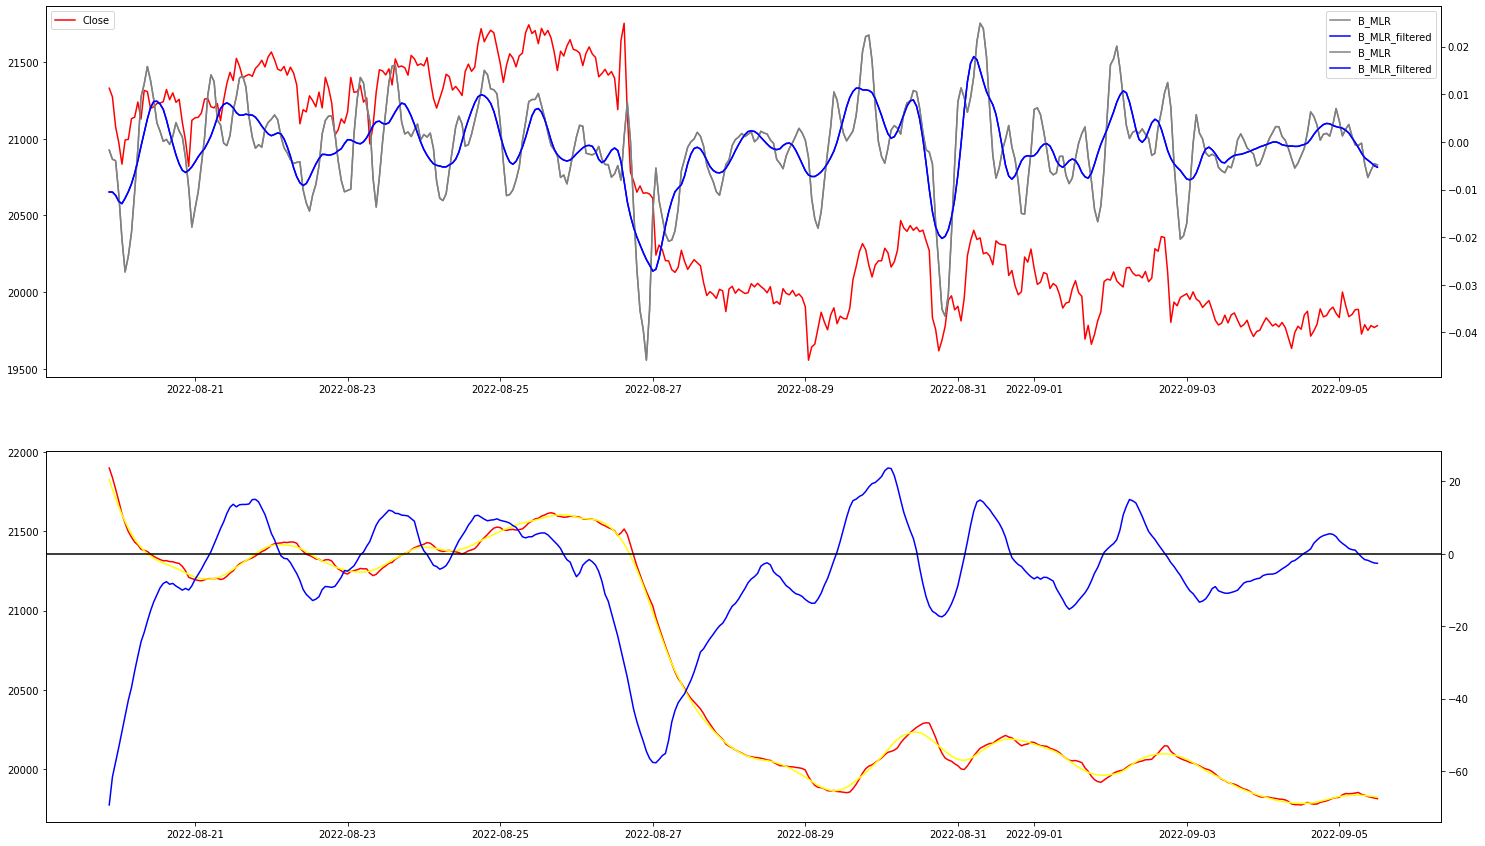

In [8]:
fig, ax_left = plt.subplots(2, figsize=(25,15))
ax_right =[]

ax_right.append(ax_left[0].twinx())
ax_right.append(ax_left[1].twinx())

ax_left[0].plot(df.Close[-400:], color='red',label='Close')
ax_right[0].plot(df.B_MLR_coefs[-400:], color='gray',label='B_MLR')
ax_right[0].plot(df.B_MLR_coefs_filtered[-400:], color='blue',label='B_MLR_filtered')
ax_left[0].legend(loc="upper left")
ax_right[0].plot(df.B_MLR_coefs[-400:], color='gray',label='B_MLR')
ax_right[0].plot(df.B_MLR_coefs_filtered[-400:], color='blue',label='B_MLR_filtered')
ax_right[0].legend(loc="upper right")

ax_left[1].plot(df.EMA20[-400:], color='red',label='RSI')
ax_left[1].plot(df.EMA20_denoised[-400:], color='yellow',label='EMA50_denoised')
ax_right[1].plot(df.EMA20_diff[-400:], color='blue',label='RSI_diff')
ax_right[1].axhline(y=0, color='black')
#sns.histplot(data=df['B_MLR_coefs'], ax = ax_leRSIft[1])

# Creating a strategy

Period : [2020-01-01 12:00:00] -> [2022-09-05 12:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 46113620527.94 $
Performance vs US Dollar : 4611361952.79 %
Buy and Hold Performence : 174.84 %
Performance vs Buy and Hold : 2637486697.95 %
Best trade : +17.38 %, the 2020-03-13 14:00:00
Worst trade : -7.24 %, the 2021-01-13 01:00:00
Worst drawBack : -7.000000000000001 %
Total fees :  6484931283.73 $

----- Trades Informations -----
Total trades on period : 1312
Number of positive trades : 1032
Number of negative trades :  280
Trades win rate ratio : 78.66 %
Average trades performance : 1.45 %
Average positive trades : 2.02 %
Average negative trades : -0.64 %

----- Plot -----


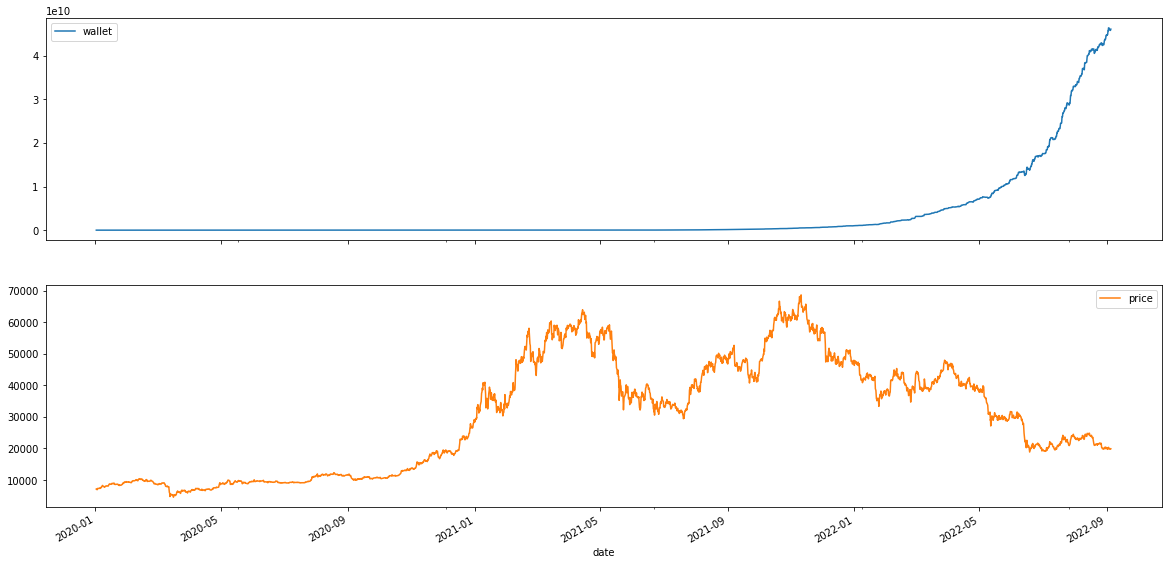

In [5]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff<0 and row.B_MLR_coefs_filtered_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff>0 and row.B_MLR_coefs_filtered_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

# Optimization

In [ ]:
result = []

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff<0 and row.B_MLR_coefs_filtered_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.B_MLR_coefs_filtered_diff>0 and row.B_MLR_coefs_filtered_diff<0 else False

for i in range(5,15, 1):
    df = computeLaggingLinearRegression(loadFromDB(f'../backtest_tools/database/database/Binance/1h/{SYMBOL}-USDT.csv').iloc[-10000:],
                                        window=i,filter_ceof=True, derivative=True,filter_method='savgol')
    equity = strategyTester(df.iloc[-7000:],buyCondition,sellCondition,optimization_process=True)
    print({'window':i,'balance':equity})
    result.append({'window':i,'balance':equity})

# Denoising

In [31]:
import multiprocessing

model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0, n_jobs=multiprocessing.cpu_count())
model.fit(df.B_MLR_coefs.values.reshape(-1, 1),df.B_MLR_coefs_filtered.values)
model.score(df.B_MLR_coefs.values.reshape(-1, 1),df.B_MLR_coefs_filtered.values)

0.7363305833324558

In [7]:
len(df.B_MLR_coefs_filtered.values)

15647

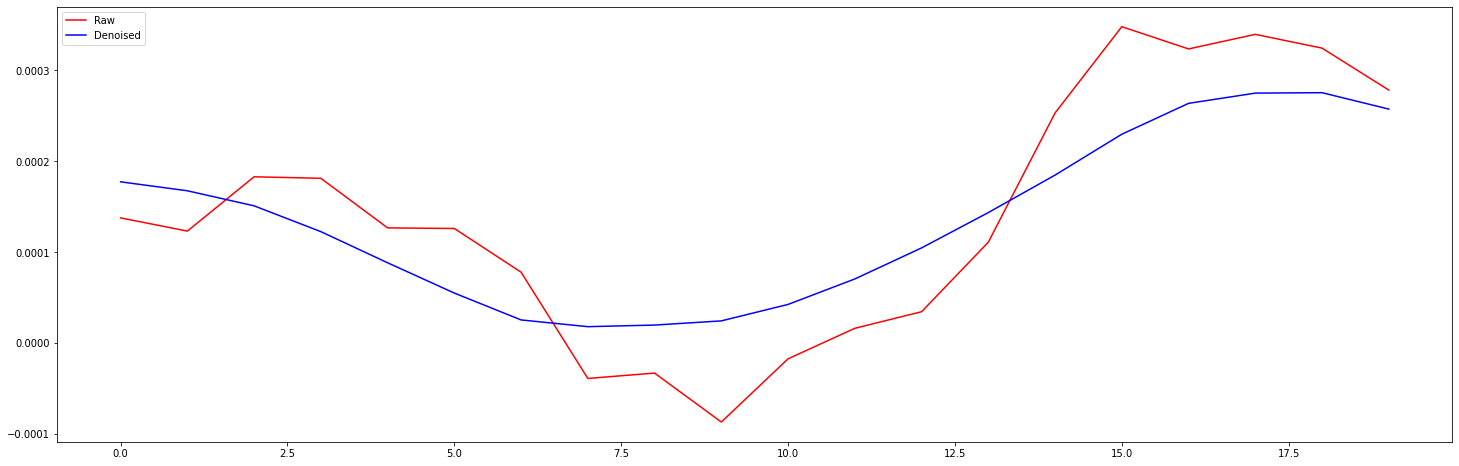

In [74]:
WINDOW=20

X = np.array([df.B_MLR_coefs.iloc[i:i+WINDOW].values for i in range(len(df)-WINDOW)])
y = np.array([df.B_MLR_coefs_filtered.iloc[i:i+WINDOW].values for i in range(len(df)-WINDOW)])

fig, ax_left = plt.subplots(1, figsize=(25,8))

ind = 165
ax_left.plot(list(range(WINDOW)),X[ind], color='red',label='Raw')
ax_left.plot(list(range(WINDOW)),y[ind], color='blue',label='Denoised')
ax_left.legend(loc="upper left")

# Denoising autoencoder

In [82]:
from keras.layers import Conv1D, Conv1DTranspose
from keras.models import Sequential
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping
import multiprocessing

max_norm_value = 2.0
input_shape = (WINDOW,1 )


# Create the model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv1D(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='linear', padding='same'))

model.summary()

# Compile and fit data
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001,restore_best_weights=True,patience=4 ,verbose=1)

model.fit(X, y,
        epochs=5,
        batch_size=128,
        validation_split=0.3,
        use_multiprocessing=True,
        workers=multiprocessing.cpu_count(),
        callbacks=[es])


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 18, 64)            256       
                                                                 
 conv1d_23 (Conv1D)          (None, 16, 16)            3088      
                                                                 
 conv1d_transpose_14 (Conv1D  (None, 18, 16)           784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_15 (Conv1D  (None, 20, 64)           3136      
 Transpose)                                                      
                                                                 
 conv1d_24 (Conv1D)          (None, 20, 1)             193       
                                                                 
Total params: 7,457
Trainable params: 7,457
Non-traina

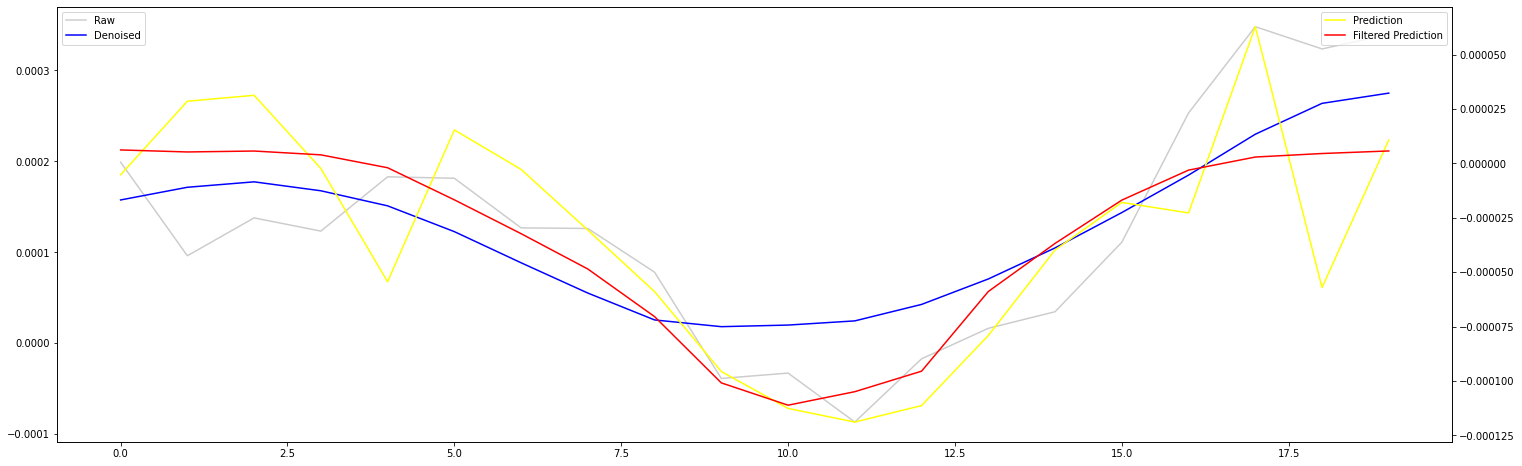

In [84]:
fig, ax_left = plt.subplots(1, figsize=(25,8))

ind = 163
ax_left.plot(list(range(WINDOW)),X[ind], color='black',alpha=0.2,label='Raw')
ax_left.plot(list(range(WINDOW)),y[ind], color='blue',label='Denoised')
ax = ax_left.twinx()
ax.plot(list(range(WINDOW)),model.predict(X[ind].reshape(1,-1))[0].reshape(1,-1)[0], color='yellow',label='Prediction')
ax.plot(list(range(WINDOW)),savgol_filter(model.predict(X[ind].reshape(1,-1))[0].reshape(1,-1)[0], 10, 2, mode='nearest'), color='red',label='Filtered Prediction')

ax_left.legend(loc="upper left")
ax.legend(loc="upper right")

# Predict next value

In [37]:
df = addIndicators(df,True,True, True)
df = computeTrixIndicator(df)
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp', 'B_MLR_coefs',
       'B_MLR_coefs_filtered', 'B_MLR_coefs_filtered_diff', 'High_Low_diff',
       'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'Stoch_RSI', 'Vortex',
       'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB',
       'OVB_EMA200', 'EVM', 'Bullish_engulfing', 'Bearish_engulfing', 'Slope',
       'Acceleration', 'Trix', 'Trix_histo'],
      dtype='object')

In [41]:
x_scaler = StandardScaler()
x_scaled = x_scaler.fit_transform(df[['Close', 'Volume', 'B_MLR_coefs','High_Low_diff',
       'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'Stoch_RSI', 'Vortex',
       'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB',
       'OVB_EMA200', 'EVM', 'Bullish_engulfing', 'Bearish_engulfing', 'Slope','Trix_histo']].values)

y_scaler = MinMaxScaler((-1,1))
y_scaled = y_scaler.fit_transform(df.B_MLR_coefs_filtered.values.reshape(-1, 1))

WINDOW=20

X = np.array([x_scaled[i-WINDOW:i] for i in range(WINDOW,len(x_scaled)-1)])
y = np.array([y_scaled[i+1] for i in range(WINDOW,len(y_scaled)-1)])

In [42]:
from keras.layers import Conv1D, Conv1DTranspose, Dense, Flatten, Dropout, LSTM, InputLayer
from keras.models import Sequential
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping
import multiprocessing
import keras


max_norm_value = 2.0
input_shape = (WINDOW,X[0].shape[1] )


# Create the model
#model = Sequential()
#model.add(Conv1D(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
#model.add(Conv1D(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
#model.add(Conv1DTranspose(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
#model.add(Conv1DTranspose(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
#model.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), padding='same'))
#model.add(Flatten())
#model.add(Dropout(0.2))
#model.add(Dense(units = 10,activation=keras.activations.relu))
#model.add(Dense(units = 5,activation=keras.activations.relu))
#model.add(Dense(units = 1,activation=keras.activations.linear))

model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(units = 32, return_sequences = False))
#model.add(LSTM(units = 64, return_sequences = True))
#model.add(LSTM(units = 32, return_sequences = True))
#for dilation_rate in (1,2,4,8,16,23):
#        model.add(Conv1D(filters=32,kernel_size=2,dilation_rate=dilation_rate,strides=1,padding='causal',activation=keras.activations.relu))
#model.add(Conv1D(filters=1,kernel_size=1)) 
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units = 10,activation=keras.activations.relu))
model.add(Dense(units = 5,activation=keras.activations.relu))
model.add(Dense(units = 1,activation=keras.activations.linear))


model.summary()

# Compile and fit data
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001,restore_best_weights=True,patience=4 ,verbose=1)

model.fit(X, y,
        epochs=100,
        batch_size=64,
        validation_split=0.3,
        use_multiprocessing=True,
        workers=multiprocessing.cpu_count(),
        callbacks=[es])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                7168      
                                                                 
 flatten_5 (Flatten)         (None, 32)                0         
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 10)                330       
                                                                 
 dense_16 (Dense)            (None, 5)                 55        
                                                                 
 dense_17 (Dense)            (None, 1)                 6         
                                                                 
Total params: 7,559
Trainable params: 7,559
Non-traina

2022-07-23 16:52:18.153776: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 54660880 exceeds 10% of free system memory.


465/465 [==============================] - 20s 31ms/step - loss: 0.0015 - val_loss: 0.0185
Epoch 2/100
465/465 [==============================] - 15s 32ms/step - loss: 3.9963e-04 - val_loss: 0.0189
Epoch 3/100
465/465 [==============================] - 14s 30ms/step - loss: 3.3574e-04 - val_loss: 0.0211
Epoch 4/100
465/465 [==============================] - 14s 31ms/step - loss: 3.0394e-04 - val_loss: 0.0235
Epoch 5/100
465/465 [==============================] - 16s 34ms/step - loss: 2.8548e-04 - val_loss: 0.0238
Epoch 5: early stopping


2022-07-23 16:53:38.227492: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 78089600 exceeds 10% of free system memory.


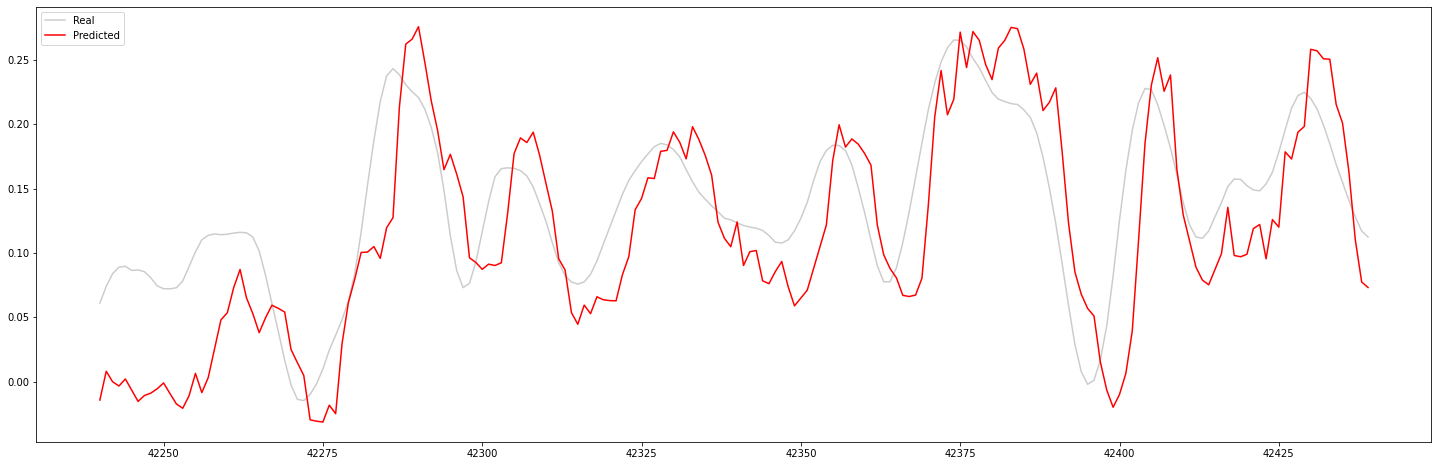

In [43]:
fig, ax = plt.subplots(1, figsize=(25,8))
ind=200


ax.plot(list(range(len(y.reshape(1,-1)[0])))[-ind:],y.reshape(1,-1)[0][-ind:], color='black',label='Real',alpha=0.2)
ax.plot(list(range(len(y.reshape(1,-1)[0])))[-ind:],model.predict(X).reshape(1,-1)[0][-ind:], color='red',label='Predicted')
ax.legend(loc="upper left")

In [118]:
import requests
response = requests.get(f'https://crypto-api.zlochteam.com/get-BTC-tweets').json()
print(f'{response["total"]} records in the dataset')

df_tweets = pd.DataFrame(response['data'])
df_tweets['Date'] = df_tweets['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tweets = df_tweets.set_index('Date')
df_tweets = df_tweets.sort_index(axis=0)
df_tweets.head()

response = requests.get(f'https://crypto-api.zlochteam.com/get-trading-view-indicators').json()
print(f'{response["total"]} records in the dataset')

df_tvta = pd.DataFrame(response['data'])
df_tvta['Date'] = df_tvta['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tvta = df_tvta.set_index('Date')
df_tvta = df_tvta.sort_index(axis=0)
df_tvta.head()

6027 records in the dataset
58738 records in the dataset


,buy,neutral,sell,symbol,timestamp
Date,,,,,
2022-05-28 15:20:20,14,9,3,BTC,1653744020
2022-05-28 15:21:20,14,9,3,BTC,1653744080
2022-05-28 15:22:20,14,9,3,BTC,1653744140
2022-05-28 15:23:21,14,10,2,BTC,1653744201
2022-05-28 15:24:21,15,10,1,BTC,1653744261


In [137]:
df = df.loc[pd.to_datetime(df_tvta.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]
df_tweets = df_tweets.loc[pd.to_datetime(df_tvta.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]
df_tvta = df_tvta.loc[pd.to_datetime(df.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]
df.head()

,Open,High,Low,Close,Volume,Timestamp,B_MLR_coefs,B_MLR_coefs_filtered,B_MLR_coefs_filtered_diff
Date,,,,,,,,,
2022-05-28 00:00:00,1734.24,1755.00,1726.79,1742.14,18819.20220,1653688800,-0.001045,-0.001593,-0.000423
2022-05-28 01:00:00,1742.13,1744.99,1703.00,1727.27,52023.46466,1653692400,-0.000504,-0.001406,-0.000015
2022-05-28 02:00:00,1727.26,1749.33,1722.26,1748.38,34782.29610,1653696000,-0.000256,-0.001062,0.000496
2022-05-28 03:00:00,1748.37,1752.39,1726.59,1730.26,34334.59350,1653699600,0.000194,-0.000580,0.001013
2022-05-28 04:00:00,1730.26,1741.97,1722.94,1729.38,21472.21510,1653703200,-0.000208,-0.000033,0.001373


In [171]:
def generateHourlyDataFormTweets(tweet_df):
    def createJoinKey(x):
        return pd.to_datetime(x.name).date().strftime("%Y%m%d")+pd.to_datetime(x.name).strftime("%H")

    tweet_df['join_key'] = tweet_df.apply(createJoinKey, axis=1)
    tweet_df = tweet_df.groupby(by='join_key',as_index=False,axis=0).sum()

    def recreateDates(x):
        date_str = x.join_key
        year = date_str[:4]
        month= date_str[4:6]
        day= date_str[6:8]
        hour= date_str[8:10]
        return datetime.strptime( f'{year}-{month}-{day} {hour}:00:00', '%Y-%m-%d %H:%M:%S')

    tweet_df['Date']=tweet_df.apply(recreateDates, axis=1)
    tweet_df = tweet_df.set_index('Date').sort_index(axis=0)
    return tweet_df.drop(columns=['join_key','timestamp'])
    
df_tweets = generateHourlyDataFormTweets(df_tweets)
df_tweets

,mean subjectivity,negative,neutral,positive
Date,,,,
2022-05-28 00:00:00,1.806284,66.0,268,266
2022-05-28 01:00:00,1.874306,79.0,261,260
2022-05-28 02:00:00,1.992644,60.0,231,309
2022-05-28 03:00:00,1.966705,70.0,266,264
2022-05-28 04:00:00,2.094448,70.0,243,286
...,...,...,...,...
2022-07-07 19:00:00,2.344846,34.0,143,423
2022-07-07 20:00:00,2.445255,25.0,139,436
2022-07-07 21:00:00,2.264426,49.0,165,385


In [173]:
def generateHourlyDataFormTVTA(tvta_df):
    def createJoinKey(x):
        return pd.to_datetime(x.name).date().strftime("%Y%m%d")+pd.to_datetime(x.name).strftime("%H")

    tvta_df['join_key'] = tvta_df.apply(createJoinKey, axis=1)
    tvta_df = tvta_df.groupby(by='join_key',as_index=False,axis=0).sum()

    def recreateDates(x):
        date_str = x.join_key
        year = date_str[:4]
        month= date_str[4:6]
        day= date_str[6:8]
        hour= date_str[8:10]
        return datetime.strptime( f'{year}-{month}-{day} {hour}:00:00', '%Y-%m-%d %H:%M:%S')

    tvta_df['Date']=tvta_df.apply(recreateDates, axis=1)
    tvta_df = tvta_df.set_index('Date').sort_index(axis=0)
    return tvta_df.drop(columns=['join_key','timestamp'])
    
df_tvta = generateHourlyDataFormTVTA(df_tvta)
df_tvta

,buy,neutral,sell
Date,,,
2022-05-28 15:00:00,425,367,248
2022-05-28 16:00:00,389,552,619
2022-05-28 17:00:00,531,534,495
2022-05-28 18:00:00,438,533,563
2022-05-28 19:00:00,270,542,748
...,...,...,...
2022-07-07 19:00:00,376,551,633
2022-07-07 20:00:00,859,488,213
2022-07-07 21:00:00,829,548,183


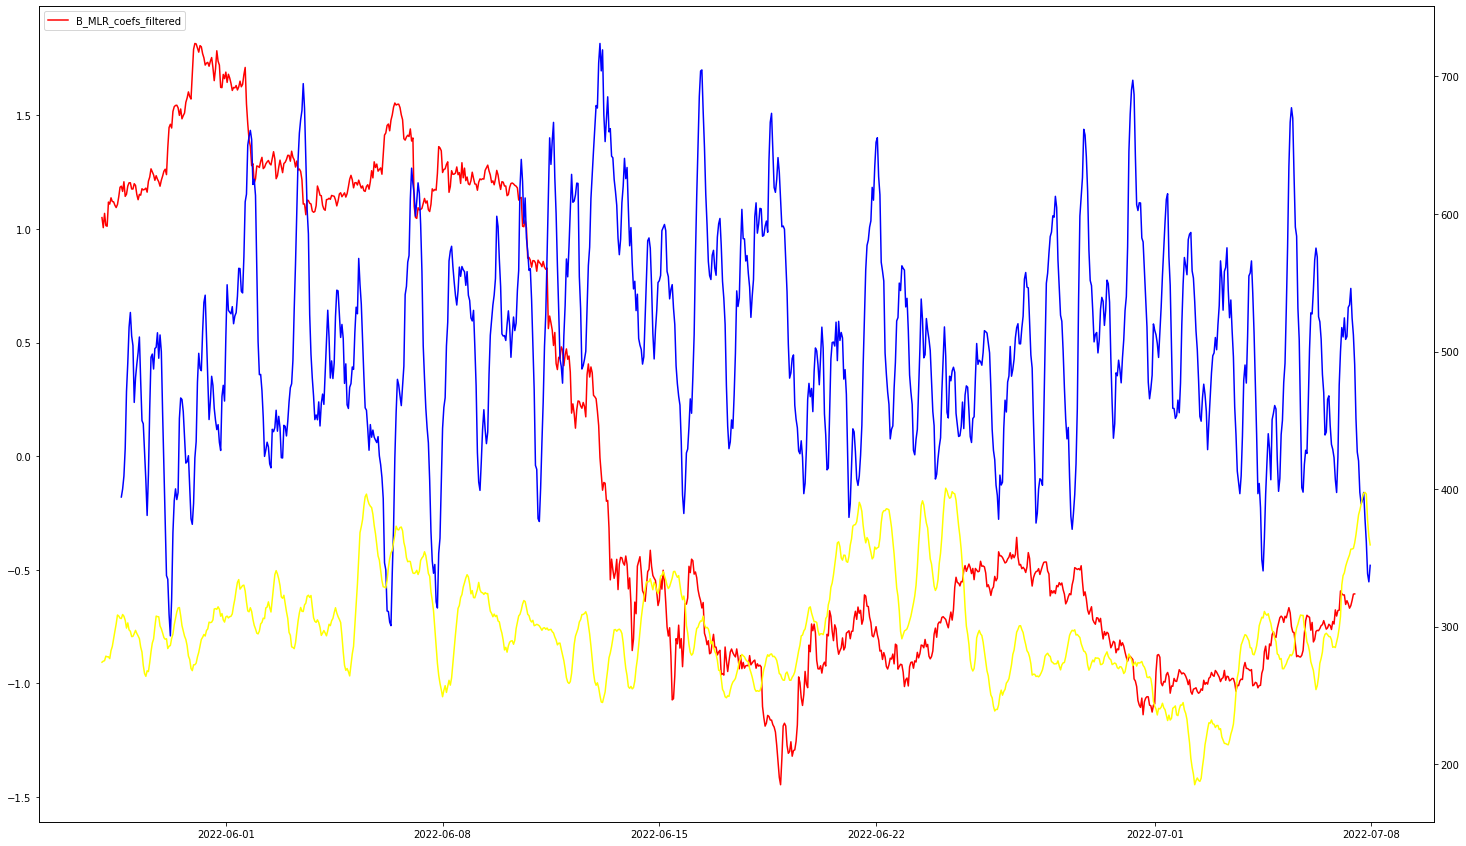

In [184]:
fig, ax_left = plt.subplots(1, figsize=(25,15))

ind = 170
#ax_left.plot(df_tweets.positive, color='yellow',label='Tweets')
ax_left.plot((df.Close-df.Close.mean())/df.Close.std(), color='red',label='B_MLR_coefs_filtered')
ax = ax_left.twinx()
ax.plot(df_tvta.index, savgol_filter(df_tvta.sell,20, 2, mode='nearest'), color='blue',label='df_tvta')
ax.plot(df_tweets.index, savgol_filter(df_tweets.positive,20, 2, mode='nearest'), color='yellow',label='Tweets')

ax_left.legend(loc="upper left")

# Using the strategy with KuCoin API

In [215]:
from kucoin.client import Market
import pandas as pd
import numpy as np
from datetime import datetime
import time
import math
client = Market(url='https://api.kucoin.com')
#[pair['symbol'] for pair in client.get_symbol_list() if pair['enableTrading']==True ]

## Find optimal parameters

In [ ]:
import traceback
results = []
for w in range(5,20):
    for c in range(5,70):
        try:
            klines = client.get_kline('ETH-USDT','15min', startAt=round(datetime.now().timestamp())-900000, endAt=round(datetime.now().timestamp()))
            #klines = client.get_kline('BTC-USDT','1day',startAt=1603100941, endAt=round(datetime.now().timestamp()),)
            df = pd.DataFrame(klines,columns=['Date','Open','High','Low','Close','Transaction volume','Transaction amount'],dtype=float)
            df = df.sort_values(by='Date')
            df['Timestamp'] = df['Date'].astype(int)
            df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
            df = df.set_index('Date')
            #print(len(df))
            #df.tail()
            coefs_2 = []
            intercepts_2 = []

            window = w
            for i in range(window,len(df)):
                ys = df['Close'].values[i-window:i]
                xs = df.Timestamp.values[i-window:i].reshape(-1, 1)
                
                model = LinearRegression().fit(xs,ys)
                
                coefs_2.append(model.coef_[0])
                intercepts_2.append(model.intercept_)
                
            ratio = sum([intercepts_2[i]/[-coef for coef in coefs_2][i] for i in range(len(coefs_2))]) / len([intercepts_2[i]/[-coef for coef in coefs_2][i] for i in range(len(coefs_2))])
            df['B_MLR'] = np.nan
            df['B_MLR'].iloc[window:] = [intercepts_2[i]/ratio+coefs_2[i] for i in range(len(coefs_2))]
            df['B_MLR_coefs'] = np.nan
            df['B_MLR_coefs'].iloc[window:] = coefs_2

            df.dropna(inplace=True)
            df['B_MLR_coefs_filtered'] = savgol_filter(df['B_MLR_coefs'].values, c, 2,mode='nearest')

            df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs_filtered'].diff()
            df.dropna(inplace=True)
            df['BUY_SELL'] = np.nan
            df['BUY_SELL'].iloc[1:] = ["HOLD" if np.sign(df['B_MLR_coefs_filtered_diff'][i-1])==np.sign(df['B_MLR_coefs_filtered_diff'][i]) else "BUY" if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 else "SELL" for i in range(1,len(df))]
            df.dropna(inplace=True)

            trades = df[df['BUY_SELL']!="HOLD"].iloc[1:][['Close','BUY_SELL']]
            trades['Change']=trades.Close.pct_change()*100
            trades = trades[trades['BUY_SELL']!="BUY"]
            if len(trades)!=0:
                dict_res = {"winrate":round(len(trades[trades.Change>0])*100/len(trades)),
                                "gain":trades.Change.sum(),
                                "window":w,
                                "coefficient":c}
                print(dict_res)
                #print(f'Gain {trades.Change.sum()} %')
                #print(f'Winrate {round(len(trades[trades.Change>0])*100/len(trades))} %')
                results.append(dict_res)
        except Exception as e:
            print(traceback.format_exc())

df_results = pd.DataFrame(data=results)
df_results.head()
df_results.to_csv('./maximize_gain.csv')


In [ ]:
%pip install plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Mesh3d(z=df_results.gain.values, x=df_results.window.values, y=df_results.coefficient.values)])
fig.update_layout(title='Maximize gain', autosize=False,
                  width=1200, height=500,
                  )
fig.show()

In [ ]:
fig = go.Figure(data=[go.Mesh3d(z=df_results.winrate.values, x=df_results.window.values, y=df_results.coefficient.values)])
fig.update_layout(title='Maximize gain', autosize=False,
                  width=1200, height=500,
                  )
fig.show()

## Implementing strategy

In [130]:
import pywt

def lowpassfilter(signal, thresh = 0.63, wavelet="db5"):#'sym5', 'coif5', 'bior2.4'
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    if len(signal) % 2==0:
        return reconstructed_signal
    else:
        return reconstructed_signal[1:]

In [125]:
import requests
response = requests.get(f'https://crypto-api.zlochteam.com/get-BTC-tweets').json()
print(f'{response["total"]} records in the dataset')

df_tweets = pd.DataFrame(response['data'])
df_tweets['Date'] = df_tweets['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tweets = df_tweets.set_index('Date')
df_tweets = df_tweets.sort_index(axis=0)
df_tweets.head()

response = requests.get(f'https://crypto-api.zlochteam.com/get-trading-view-indicators').json()
print(f'{response["total"]} records in the dataset')

df_tvta = pd.DataFrame(response['data'])
df_tvta['Date'] = df_tvta['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tvta = df_tvta.set_index('Date')
df_tvta = df_tvta.sort_index(axis=0)
df_tvta.head()



455 records in the dataset
3192 records in the dataset


,buy,neutral,sell,symbol,timestamp
Date,,,,,
2022-05-28 15:20:20,14,9,3,BTC,1653744020
2022-05-28 15:21:20,14,9,3,BTC,1653744080
2022-05-28 15:22:20,14,9,3,BTC,1653744140
2022-05-28 15:23:21,14,10,2,BTC,1653744201
2022-05-28 15:24:21,15,10,1,BTC,1653744261


Gain : 136 %
Winrate : 63 %
Total trades : 587


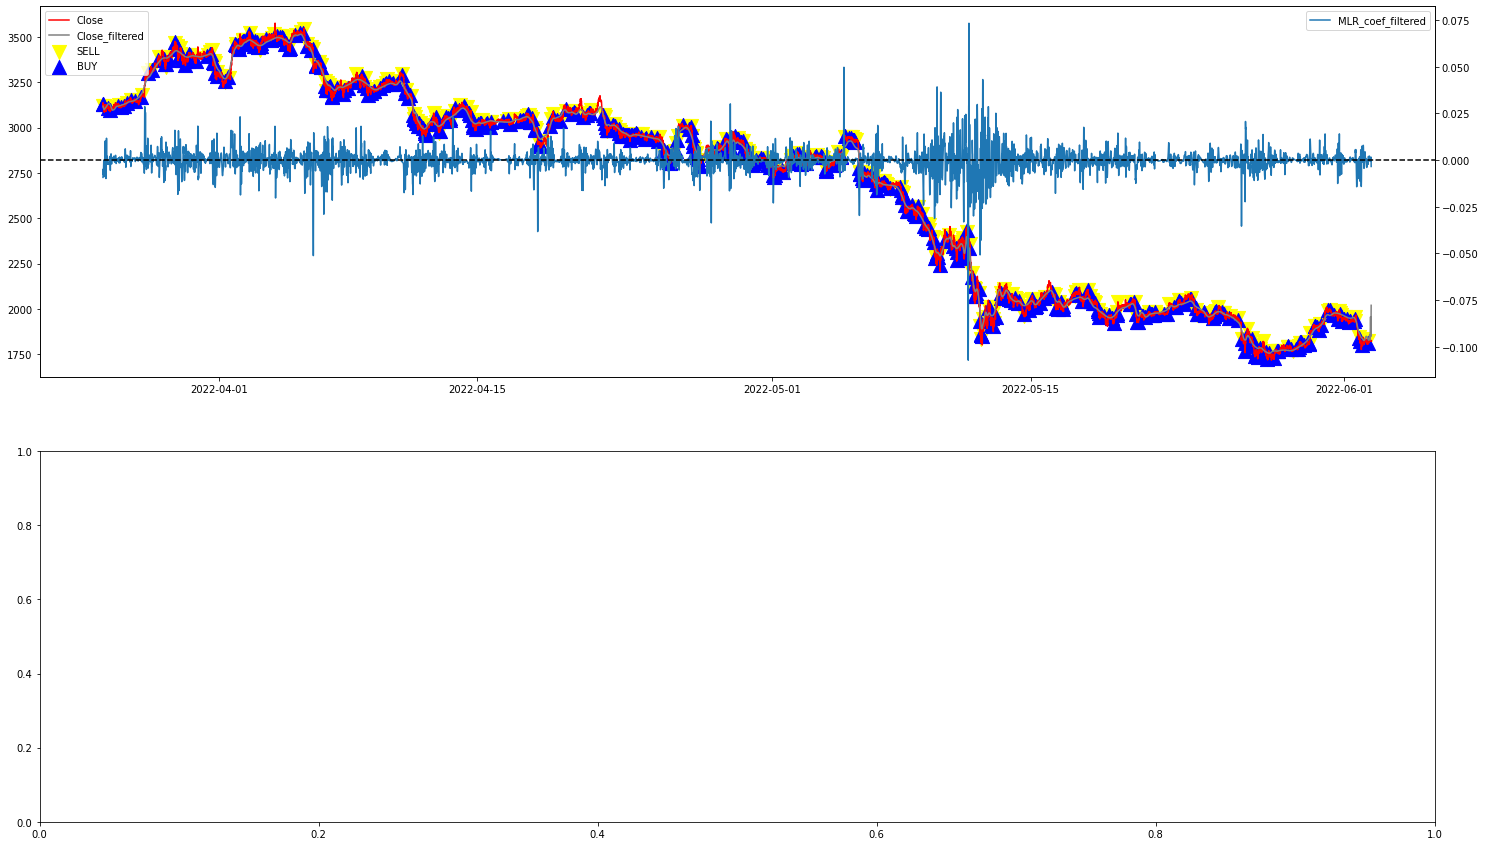

In [174]:
df = pd.read_csv('./data/ETH-USDT.csv',names=['Date','Open','High','Low','Close','Volume'])
df['Date'] = df['Date'].apply(lambda x: int(str(x)[:-3]))
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')


df = df[-20000:]
addIndicators(df)
df['Close_filtered'] = lowpassfilter(df['Close'].values, 0.04)


coefs_2 = []
window = 8
for i in range(window,len(df)):
    ys = df['Close'].values[i-window:i]
    xs = df.Timestamp.values[i-window:i].reshape(-1, 1)
    
    model = LinearRegression().fit(xs,ys)
    
    coefs_2.append(model.coef_[0])
    
df['B_MLR_coefs'] = np.nan
df['B_MLR_coefs'].iloc[window:] = coefs_2

df.dropna(inplace=True)
df['B_MLR_coefs_filtered'] =  lowpassfilter(df['B_MLR_coefs'].values, 0.1)#savgol_filter(df['B_MLR_coefs'].values, 19, 2,mode='wrap',deriv=0)

df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs_filtered'].diff()
df.dropna(inplace=True)
df['BUY_SELL'] = np.nan
##df['BUY_SELL'].iloc[1:] = ["HOLD" if np.sign(df['B_MLR_coefs_filtered_diff'][i-1])==np.sign(df['B_MLR_coefs_filtered_diff'][i]) else "BUY" if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 and df['B_MLR_coefs_filtered'][i]<=-0.000025/2 else "SELL" if  df['B_MLR_coefs_filtered_diff'][i-1]>0 and df['B_MLR_coefs_filtered_diff'][i]<0 and df['B_MLR_coefs_filtered'][i]>=0.000020 else "HOLD" for i in range(1,len(df))]
#df['BUY_SELL'].iloc[1:] = ["HOLD" if np.sign(df['B_MLR_coefs_filtered_diff'][i-1])==np.sign(df['B_MLR_coefs_filtered_diff'][i]) else "BUY" if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 else "SELL" if  (df['B_MLR_coefs_filtered_diff'][i-1]>0 and df['B_MLR_coefs_filtered_diff'][i]<0) else "HOLD" for i in range(1,len(df))]
#df.dropna(inplace=True)

trades = []
df['BUY'] = np.nan
df['SELL'] = np.nan
OPENED = False
for i in range(1,len(df)):
    if OPENED == False:
        if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 and df['B_MLR_coefs_filtered'][i]<0  and df['Stoch_RSI'][i]>0.2 :
            df['BUY'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'BUY'
            trades.append(df.iloc[i].values)
            OPENED = True
            LAST_BUY_PRICE = df.Close.iloc[i]
    else:
        if df['B_MLR_coefs_filtered_diff'][i-1]>0 and df['B_MLR_coefs_filtered_diff'][i]<0 :
            df['SELL'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'SELL'
            trades.append(df.iloc[i].values)
            OPENED = False
        elif df['Close'][i]<=0.95*LAST_BUY_PRICE:
            df['SELL'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'SELL'
            trades.append(df.iloc[i].values)
            OPENED = False
            
        
trades = pd.DataFrame(trades, columns=df.columns)
trades['Change']=trades.Close.pct_change()*100
trades = trades[trades['BUY_SELL']=='SELL']
print(f"Gain : {round(trades.Change.sum())} %")
print(f"Winrate : {round(100*len(trades[trades['Change']>0].Change)/len(trades))} %")
print(f"Total trades : {len(trades)}")

#start = df_tvta.timestamp.iloc[0]
#df = df[df['Timestamp']>=start]
#df_tweets= df_tweets[df_tweets['timestamp']>=start]


fig, ax_left = plt.subplots(2, figsize=(25,15))

ax_left[0].plot(df.Close, color='red',label='Close')
ax_left[0].plot(df.Close_filtered, color='gray',label='Close_filtered')
ax_left[0].scatter(df.index, df['SELL'], color='yellow',label='SELL',marker='v',s=200)
ax_left[0].scatter(df.index, df['BUY'], color='blue',label='BUY',marker='^',s=200)
ax_right = ax_left[0].twinx()
ax_right.plot(df.B_MLR_coefs_filtered,label='MLR_coef_filtered')
ax_right.axhline(y=0, color='black', linestyle='--')
ax_left[0].legend(loc="upper left")
ax_right.legend(loc="upper right")

#ax_left[1].plot(df.Stoch_RSI, color='red',label='Stoch_RSI')
#ax_left[1].axhline(y=0.2, color='black', linestyle='--')
#ax_left[1].axhline(y=0.8, color='black', linestyle='--')

1500
Gain : -6 %
Winrate : 0 %
Total trades : 4


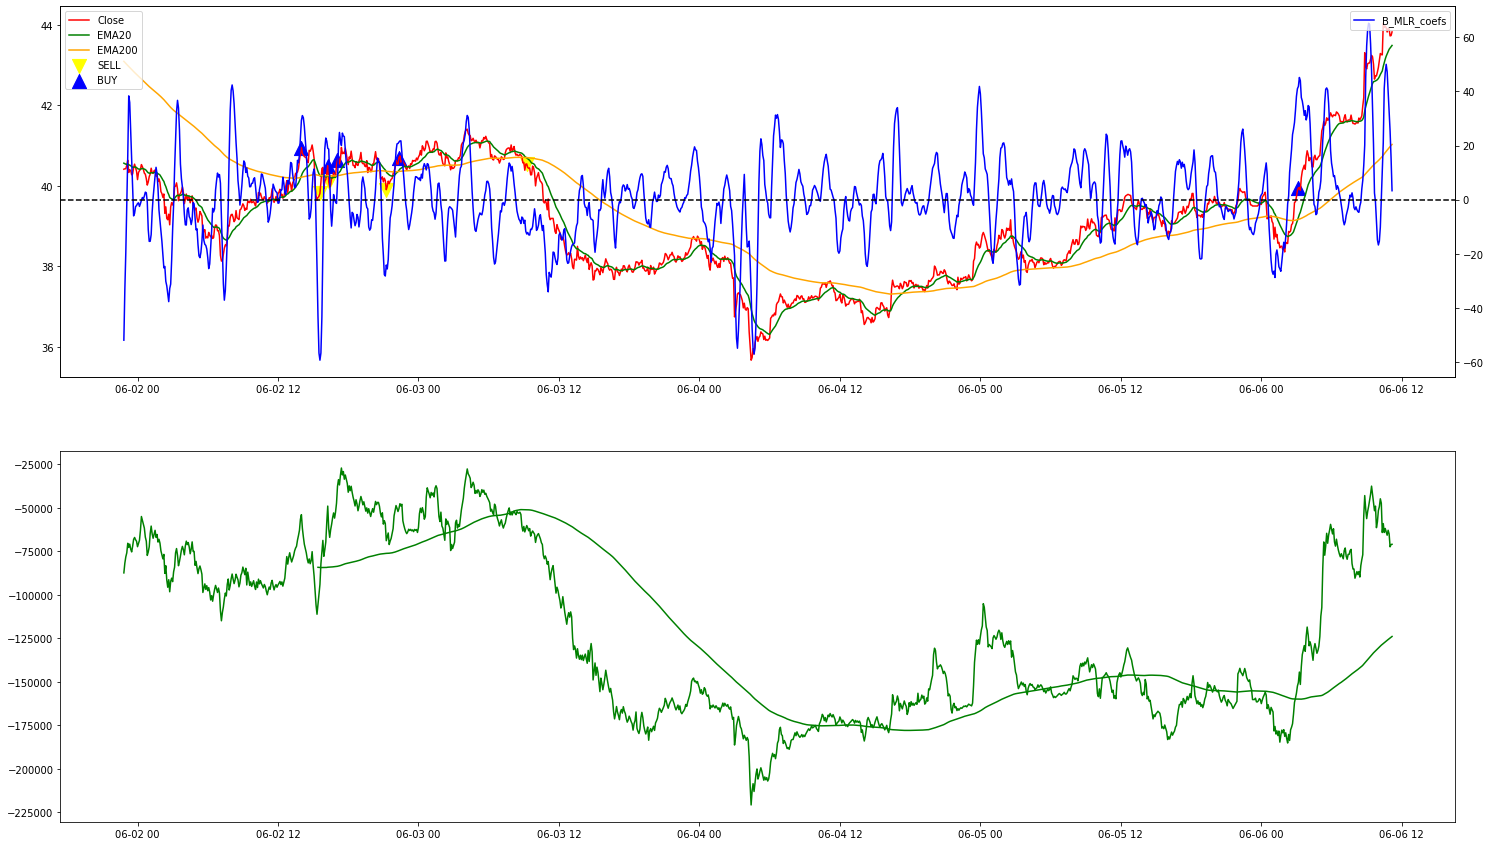

In [264]:

klines = client.get_kline('SOL-USDT','5min', startAt=round(datetime.now().timestamp())-9900000, endAt=round(datetime.now().timestamp()))
df = pd.DataFrame(klines,columns=['Date','Open','High','Low','Close','Volume','Amount'],dtype=float)
df = df.sort_values(by='Date')
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')
print(len(df))
addIndicators(df)

#df = pd.read_csv('../backtest_tools/database/database/Binance/5m/AVAX-USDT.csv',names=['Date','Open','High','Low','Close','Volume'])
#df = df.iloc[1:]
#df['Date'] = df['Date'].apply(lambda x: int(str(x)[:-3]))
#df = df.astype(float)
#df['Timestamp'] = df['Date'].astype(int)
#df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
#df = df.set_index('Date')
#df = addIndicators(df)
#df=df.iloc[-20000:]
#df['Close_filtered'] = lowpassfilter(df['Close'].values, 0.04)

coefs = []
window = 10
for i in range(window,len(df)):
    ys = df['Close'].values[i-window:i]
    xs = df.Timestamp.values[i-window:i].reshape(-1, 1)
    
    model = LinearRegression().fit(xs,ys)
    
    coefs.append(model.coef_[0])
    
df['B_MLR_coefs'] = np.nan
df['B_MLR_coefs'].iloc[window:] = coefs

trixLength = 5
trixSignal = 21

#df['TRIX'] = ema_indicator(ema_indicator(ema_indicator(df['Close'], window=trixLength), window=trixLength), window=trixLength)
#df['TRIX_PCT'] = df["TRIX"].pct_change()*100
#df['TRIX_SIGNAL'] = sma_indicator(df['TRIX_PCT'],trixSignal)
#df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
#df.dropna(inplace=True)
    
    
df['B_MLR_coefs_filtered'] =  ema_indicator(ema_indicator(ema_indicator(df['B_MLR_coefs'], window=trixLength), window=trixLength), window=trixLength)#lowpassfilter(df['B_MLR_coefs'].values, 0.1)

df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs_filtered'].diff()

df['EMA200_normalized'] = (df.EMA200-df.EMA200.mean())/df.EMA200.std()
df['B_MLR_coefs_2'] = df['B_MLR_coefs']*10**5
df['New_ind'] = ((df.EMA200-df.EMA200.mean())/df.EMA200.std())-df.B_MLR_coefs*10**5

df.dropna(inplace=True)
df['BUY_SELL'] = np.nan


trades = []
df['BUY'] = np.nan
df['SELL'] = np.nan
OPENED = False
for i in range(1,len(df)):
    if OPENED == False:
        if df.EMA200[i-1]>df.EMA20[i-1] and df.EMA200[i]<df.EMA20[i] and df.B_MLR_coefs[i]>0:
            df['BUY'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'BUY'
            trades.append(df.iloc[i].values)
            OPENED = True
            LAST_BUY_PRICE = df.Close.iloc[i]
    else:
        if  df.EMA200[i-1]<df.EMA20[i-1] and df.EMA200[i]>df.EMA20[i]:
            df['SELL'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'SELL'
            trades.append(df.iloc[i].values)
            OPENED = False

    #if OPENED == False:
    #    if df['B_MLR_coefs_filtered_diff'][i]>0 and df['B_MLR_coefs'][i]<0 and (df['Stoch_RSI'][i]>0.2 and df['Close'][i]>df['EMA200'][i]):
    #        df['BUY'].iloc[i] = df.Close.iloc[i]
    #        df['BUY_SELL'].iloc[i] = 'BUY'
    #        trades.append(df.iloc[i].values)
    #        OPENED = True
    #        LAST_BUY_PRICE = df.Close.iloc[i]
    #else:
    #    if  df['B_MLR_coefs_filtered_diff'][i]<0 and df['B_MLR_coefs'][i]>0:
    #        df['SELL'].iloc[i] = df.Close.iloc[i]
    #        df['BUY_SELL'].iloc[i] = 'SELL'
    #        trades.append(df.iloc[i].values)
    #        OPENED = False
    
    
    
        #elif df['Close'][i]<=0.95*LAST_BUY_PRICE:
        #    df['SELL'].iloc[i] = df.Close.iloc[i]
        #    df['BUY_SELL'].iloc[i] = 'SELL'
        #    trades.append(df.iloc[i].values)
        #    OPENED = False
            
        
trades = pd.DataFrame(trades, columns=df.columns)
trades['Change']=trades.Close.pct_change()*100
trades = trades[trades['BUY_SELL']=='SELL']
print(f"Gain : {round(trades.Change.sum())} %")
print(f"Winrate : {round(100*len(trades[trades['Change']>0].Change)/len(trades))} %")
print(f"Total trades : {len(trades)}")
fig, ax_left = plt.subplots(2, figsize=(25,15))

ax_left[0].plot(df.Close, color='red',label='Close')
ax_left[0].plot(df.EMA20, color='green',label='EMA20')
ax_left[0].plot(df.EMA200, color='orange',label='EMA200')

#ax_left[0].plot(df.Close_filtered, color='gray',label='Close_filtered')
ax_left[0].scatter(df.index, df['SELL'], color='yellow',label='SELL',marker='v',s=200)
ax_left[0].scatter(df.index, df['BUY'], color='blue',label='BUY',marker='^',s=200)
ax_right = ax_left[0].twinx()
ax_right.plot(df.B_MLR_coefs*10**5,label='B_MLR_coefs',color='blue')
ax_right.axhline(y=0, color='black', linestyle='--')
ax_left[0].legend(loc="upper left")
ax_right.legend(loc="upper right")

ax_left[1].plot(df.OVB, color='green',label='OVB')
ax_left[1].plot(df.OVB.rolling(200).mean(), color='green',label='OVB_mean')

1500
Gain : -1 %
Winrate : 47 %
Total trades : 17


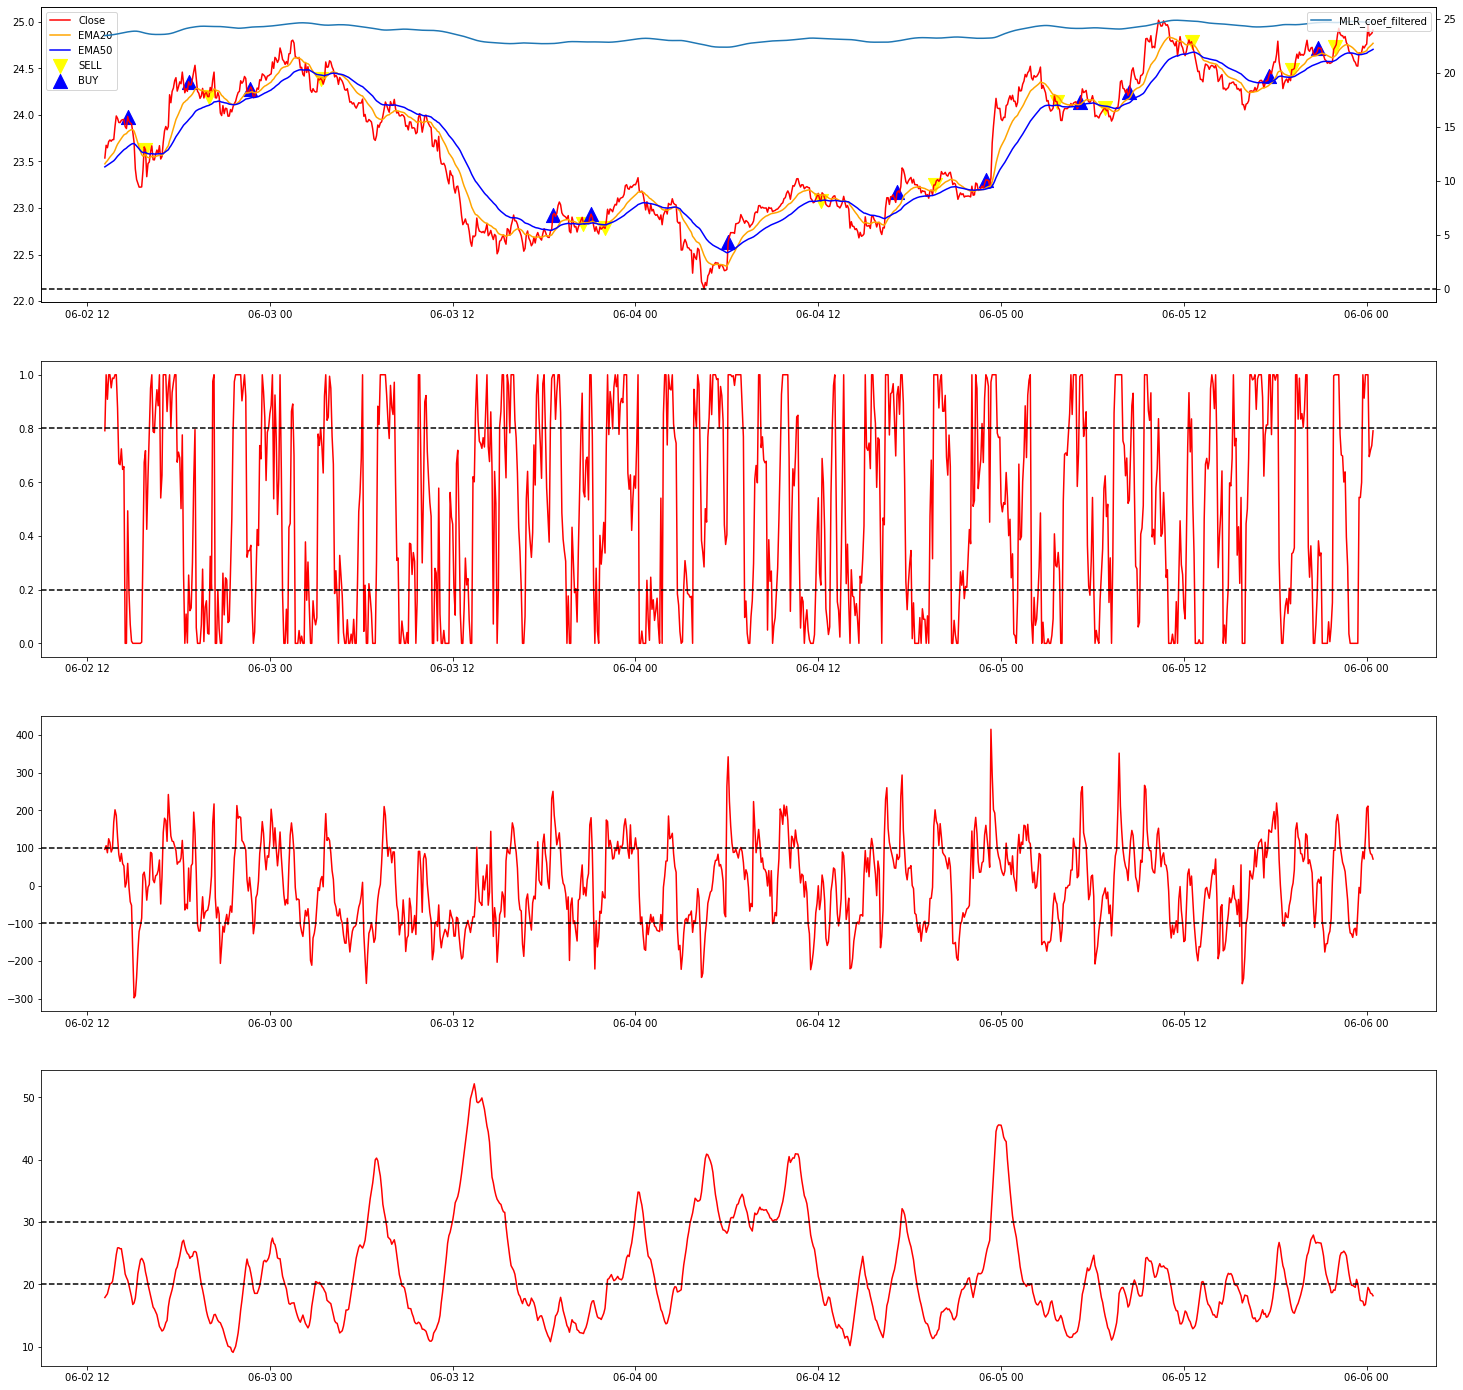

In [224]:

klines = client.get_kline('AVAX-USDT','5min', startAt=round(datetime.now().timestamp())-9900000, endAt=round(datetime.now().timestamp()))

df = pd.DataFrame(klines,columns=['Date','Open','High','Low','Close','Volume','Amount'],dtype=float)
df = df.sort_values(by='Date')
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')
print(len(df))
df.tail()
addIndicators(df)

#df['Close_filtered'] = lowpassfilter(df['Close'].values, 0.04)


coefs = []
window = 8
for i in range(window,len(df)):
    ys = df['Close'].values[i-window:i]
    xs = df.Timestamp.values[i-window:i].reshape(-1, 1)
    
    model = LinearRegression().fit(xs,ys)
    
    coefs.append(model.coef_[0])
    
df['B_MLR_coefs'] = np.nan
df['B_MLR_coefs'].iloc[window:] = coefs

trixLength = 9
trixSignal = 21

#df['TRIX'] = ema_indicator(ema_indicator(ema_indicator(df['Close'], window=trixLength), window=trixLength), window=trixLength)
#df['TRIX_PCT'] = df["TRIX"].pct_change()*100
#df['TRIX_SIGNAL'] = sma_indicator(df['TRIX_PCT'],trixSignal)
#df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
#df.dropna(inplace=True)
    
    
df['B_MLR_coefs_filtered'] =  ema_indicator(ema_indicator(ema_indicator(df['Close'], window=trixLength), window=trixLength), window=trixLength)#lowpassfilter(df['B_MLR_coefs'].values, 0.1)

df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs_filtered'].diff(1)
df.dropna(inplace=True)
df['BUY_SELL'] = np.nan


trades = []
df['BUY'] = np.nan
df['SELL'] = np.nan
OPENED = False
for i in range(1,len(df)):
    if OPENED == False:
        if df['B_MLR_coefs_filtered_diff'][i]>0 and df['B_MLR_coefs'][i]<0 and (df['Stoch_RSI'][i]>0.2 and df['Close'][i]>df['EMA20'][i]):
            df['BUY'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'BUY'
            trades.append(df.iloc[i].values)
            OPENED = True
            LAST_BUY_PRICE = df.Close.iloc[i]
    else:
        if  df['B_MLR_coefs_filtered_diff'][i]<0 and df['B_MLR_coefs'][i]>0:
            df['SELL'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'SELL'
            trades.append(df.iloc[i].values)
            OPENED = False
        elif df['Close'][i]<=0.95*LAST_BUY_PRICE:
            df['SELL'].iloc[i] = df.Close.iloc[i]
            df['BUY_SELL'].iloc[i] = 'SELL'
            trades.append(df.iloc[i].values)
            OPENED = False
            
        
trades = pd.DataFrame(trades, columns=df.columns)
trades['Change']=trades.Close.pct_change()*100
trades = trades[trades['BUY_SELL']=='SELL']
print(f"Gain : {round(trades.Change.sum())} %")
print(f"Winrate : {round(100*len(trades[trades['Change']>0].Change)/len(trades))} %")
print(f"Total trades : {len(trades)}")

#start = df_tvta.timestamp.iloc[0]
#df = df[df['Timestamp']>=start]
#df_tweets= df_tweets[df_tweets['timestamp']>=start]

df = df.iloc[-1000:]
fig, ax_left = plt.subplots(4, figsize=(25,25))

ax_left[0].plot(df.Close, color='red',label='Close')
ax_left[0].plot(df.EMA20, color='orange',label='EMA20')
ax_left[0].plot(df.EMA50, color='blue',label='EMA50')
#ax_left[0].plot(df.Close_filtered, color='gray',label='Close_filtered')
ax_left[0].scatter(df.index, df['SELL'], color='yellow',label='SELL',marker='v',s=200)
ax_left[0].scatter(df.index, df['BUY'], color='blue',label='BUY',marker='^',s=200)
ax_right = ax_left[0].twinx()
ax_right.plot(df.B_MLR_coefs_filtered,label='MLR_coef_filtered')

ax_right.axhline(y=0, color='black', linestyle='--')
ax_left[0].legend(loc="upper left")
ax_right.legend(loc="upper right")

ax_left[1].plot(df.Stoch_RSI, color='red',label='Stoch_RSI')
ax_left[1].axhline(y=0.2, color='black', linestyle='--')
ax_left[1].axhline(y=0.8, color='black', linestyle='--')

ax_left[2].plot(df.CCI, color='red',label='CCI')
ax_left[2].axhline(y=100, color='black', linestyle='--')
ax_left[2].axhline(y=-100, color='black', linestyle='--')


ax_left[3].plot(df.ADX, color='red',label='ADX')
ax_left[3].axhline(y=30, color='black', linestyle='--')
ax_left[3].axhline(y=20, color='black', linestyle='--')


In [170]:
trades.Change.mean()

0.315127641043246

In [171]:
trades[trades['Change']>0].Change.mean()

0.6650002976872793

In [172]:
trades[trades['Change']<0].Change.mean()

-0.31645093188176304

In [173]:
trades[trades['Change']<0.1]['Change'].count()

225

# Live testing

In [ ]:

cryptos = ['KDA']#['ETH','BTC','SOL','KDA']
crypto_channels_slack = {'BTC':'B03EMHUP3C5/t9xTAmELtK2zfIDvAzG5Z5gz',
                'ETH':'B03GF6XNQ83/HFHrBIr8zplBHAUOzuVXb3K3',
                'KDA':'B03GHJ7JVGC/uKUFV8x2wFPemUFqwvDKQHHM',
                'SOL':'B03GCAC9ZJR/83P3iYjj0m7OuC0w6yjIECRO'}
POSITION_OPENED = {crypto:False for crypto in cryptos}

while True:
    try:
        for crypto in cryptos : 
            klines = client.get_kline(f'{crypto}-USDT','1min', startAt=round(datetime.now().timestamp())-100000, endAt=round(datetime.now().timestamp()))
            df = pd.DataFrame(klines,columns=['Date','Open','High','Low','Close','Transaction volume','Transaction amount'],dtype=float)
            df = df.sort_values(by='Date')
            df['Timestamp'] = df['Date'].astype(int)
            df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
            df = df.set_index('Date')
            print(len(df))
            df.tail()

            coefs_2 = []
            intercepts_2 = []

            window = 8
            for i in range(window,len(df)):
                ys = df['Close'].values[i-window:i]
                xs = df.Timestamp.values[i-window:i].reshape(-1, 1)
                
                model = LinearRegression().fit(xs,ys)
                
                coefs_2.append(model.coef_[0])
                intercepts_2.append(model.intercept_)
                
            ratio = sum([intercepts_2[i]/[-coef for coef in coefs_2][i] for i in range(len(coefs_2))]) / len([intercepts_2[i]/[-coef for coef in coefs_2][i] for i in range(len(coefs_2))])
            df['B_MLR'] = np.nan
            df['B_MLR'].iloc[window:] = [intercepts_2[i]/ratio+coefs_2[i] for i in range(len(coefs_2))]
            df['B_MLR_coefs'] = np.nan
            df['B_MLR_coefs'].iloc[window:] = coefs_2

            df.dropna(inplace=True)
            df['B_MLR_coefs_filtered'] = savgol_filter(df['B_MLR_coefs'].values, 20, 2,mode='nearest')

            df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs_filtered'].diff()
            df.dropna(inplace=True)
            df['BUY_SELL'] = np.nan
            df['BUY_SELL'].iloc[1:] = ["HOLD" if np.sign(df['B_MLR_coefs_filtered_diff'][i-1])==np.sign(df['B_MLR_coefs_filtered_diff'][i]) else "BUY" if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 else "SELL" for i in range(1,len(df))]
            df.dropna(inplace=True)

            trades = df[df['BUY_SELL']!="HOLD"].iloc[1:][['Close','BUY_SELL']]
            trades['Change']=trades.Close.pct_change()*100
            trades = trades[trades['BUY_SELL']!="BUY"]
            print(df[['B_MLR_coefs_filtered_diff','BUY_SELL']].iloc[-5:])
            if 'BUY' in df[['BUY_SELL']].iloc[-5:].values and POSITION_OPENED[crypto]==False:
                results = df.iloc[-5:]
                print(f"BUY at {results[results['BUY_SELL']=='BUY'].Close.values}")
                #logging.debug(f'Time to buy {crypto} at {df["Close"].iloc[-1]} USDT !')
                #slack_api.sendMessage(f'Time to buy {crypto} at {df["Close"].iloc[-1]} USDT !',crypto_channels_slack[crypto])
                POSITION_OPENED[crypto] = True
            elif 'SELL' in df[['BUY_SELL']].iloc[-5:].values and POSITION_OPENED[crypto]==True:
                results = df.iloc[-5:]
                print(f"SELL at {results[results['BUY_SELL']=='SELL'].Close.values}")
                #logging.debug(f'Time to sell {crypto} at {df["Close"].iloc[-1]} USDT !')
                #slack_api.sendMessage(f'Time to sell {crypto} at {df["Close"].iloc[-1]} USDT !',crypto_channels_slack[crypto])
                POSITION_OPENED[crypto] = False        
        time.sleep(60)
    except:
        print(traceback.format_exc())
   